In [1]:
from gwpy.table import EventTable
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys, traceback
from gwpy.time import from_gps, to_gps
from datetime import datetime, timedelta
from gwpy.timeseries import TimeSeries, TimeSeriesDict, StateVector, StateVectorDict, StateTimeSeries
from gwpy.segments import DataQualityFlag, Segment 
from gwpy.signal import filter_design
from gwpy.astro import inspiral_range, inspiral_range_psd, range_timeseries
from gwpy.plot import Plot
import datetime
import lal
import scipy.stats
import math
import os
import warnings
import glob
# warnings.filterwarnings('ignore')

%matplotlib inline
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["legend.fontsize"] = 20
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = "white"
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

/disk/home/hirotaka.yuzurihara/mambaforge/envs/igwn-py310/lib/python3.10/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


In [2]:
time = float(to_gps(datetime.datetime(2023, 5, 25)))
print(time, time+24*3600)
utc = from_gps(time)
print(utc)
utc = utc.strftime('%Y%m%d')
print(utc)

1369008018.0 1369094418.0
2023-05-25 00:00:00
20230525


In [3]:
#parameter
time_width = 3600
margin = 5
hp_freq = 5
fftlength = 32

#getting data
gps_beg = time
gps_end = time + time_width
gps_beg_head = int(gps_beg/100000)
gps_end_head = int(gps_end/100000)

In [4]:
# path = '/home/ryoya.ishikawa/prac/newtrigger/K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ/*.xml' # ファイル名一覧を取得したいディレクトリのパス
# files = []
# files = glob.glob(path) # ファイル名一覧を取得

In [5]:
ch = ["K1:CAL-CS_PROC_DARM_STRAIN_DBL_DQ", "K1:GRD-IFO_STATE_N"]

In [6]:
# # reading data
# if gps_beg_head == gps_end_head:
#     cache_file="/home/detchar/cache/Cache_GPS/%s.ffl" % gps_beg_head
# else:
#     cache1="/home/detchar/cache/Cache_GPS/%s.ffl" % gps_beg_head
#     cache2="/home/detchar/cache/Cache_GPS/%s.ffl" % gps_end_head 
#     cache_file="%s_%s.ffl" % (gps_beg, gps_end)

#     with open(cache_file, 'w') as outfile:
#         for i in [cache1, cache2]:
#             with open(i) as infile:
#                 outfile.write(infile.read())

cache_file="/home/detchar/cache/1368975618_1371337218_O4a.ffl"

input_ = TimeSeriesDict.read(cache_file, ch, start=gps_beg-margin, end=gps_end+margin, nproc=4, verbose=True)
input = input_[ch[0]]

#highpass filter
input_high = input.highpass(hp_freq, filtfilt = True)
data = input_high.crop(gps_beg, gps_end)

#whitening
wt = input_high.whiten(fftlength, fftlength/2)
data_wt = wt.crop(gps_beg, gps_end)

Reading (<built-in function format>): |████████████████████████████████████████████████████████████████████████████████████████| 114/114 (100%) ETA 00:00 


In [7]:
# events = EventTable.read(files, tablename='sngl_burst', columns=['peak', 'central_freq', 'snr', 'duration', 'bandwidth'])
# duration =time_width

In [8]:
fmin = 30
fftlength = 4
range_time = range_timeseries(data, 30, fftlength=fftlength, fmin=fmin)

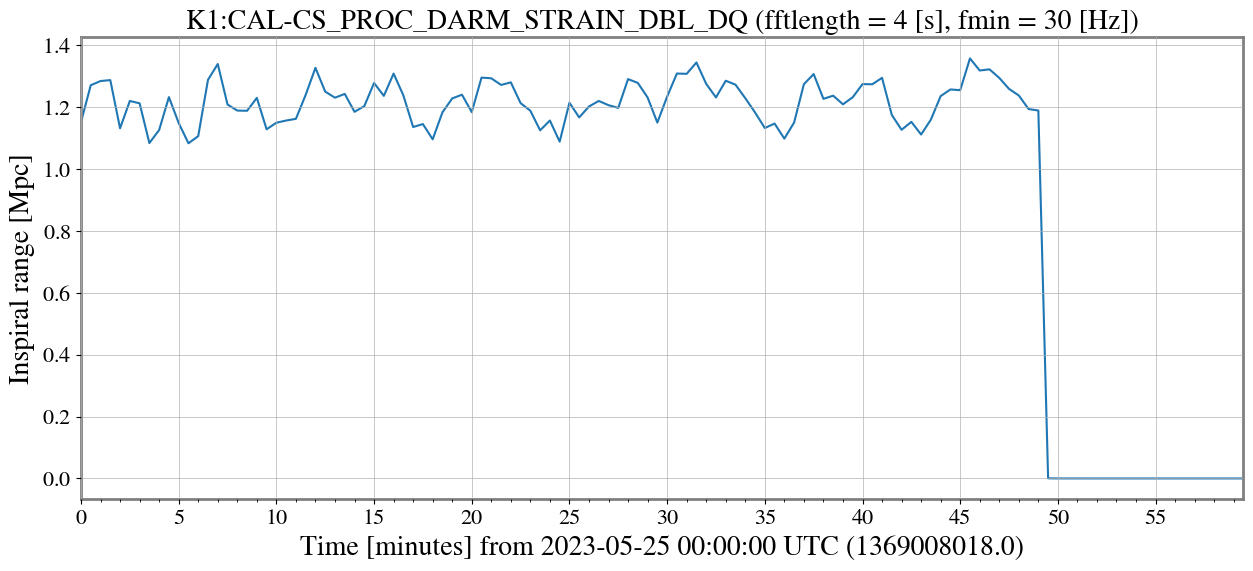

In [11]:
plot = range_time.plot(figsize=(15, 6))
ax = plot.gca()
ax.set_ylabel('Inspiral range [Mpc]')
ax.set_title('%s (fftlength = %s [s], fmin = %s [Hz])' % (ch[0], fftlength, fmin))
ax.set_epoch(time)
#filename = '/home/ryoya.ishikawa/prac/fig_omicron/range_K1-CAL_CS_PROC_DARM_STRAIN_DBL_DQ_OMICRON-%s-%s.png' % (time, time_width)
filename = 'range.png'
plt.savefig(filename)

# stride = 60
# plot = events.event_rate(stride, start=time, end=time+duration).step(figsize=[15,6])
# ax = plot.gca()
# ax.set_xlim(time, time+duration)
# ax.set_epoch(time)
# ax.set_ylabel('Trigger rate [Hz]')
# ax.set_title('%s (SNR > 5, stride = %s [s])' % (ch[0], stride))
# filename = '/home/ryoya.ishikawa/prac/fig_omicron/rate_%s_K1-CAL_CS_PROC_DARM_STRAIN_DBL_DQ_OMICRON-%s-%s.png' % (stride, time, time_width)
# plt.savefig(filename)

Text(0, 0.5, 'ASD [1/$\\sqrt{\\mathrm{Hz}}$]')

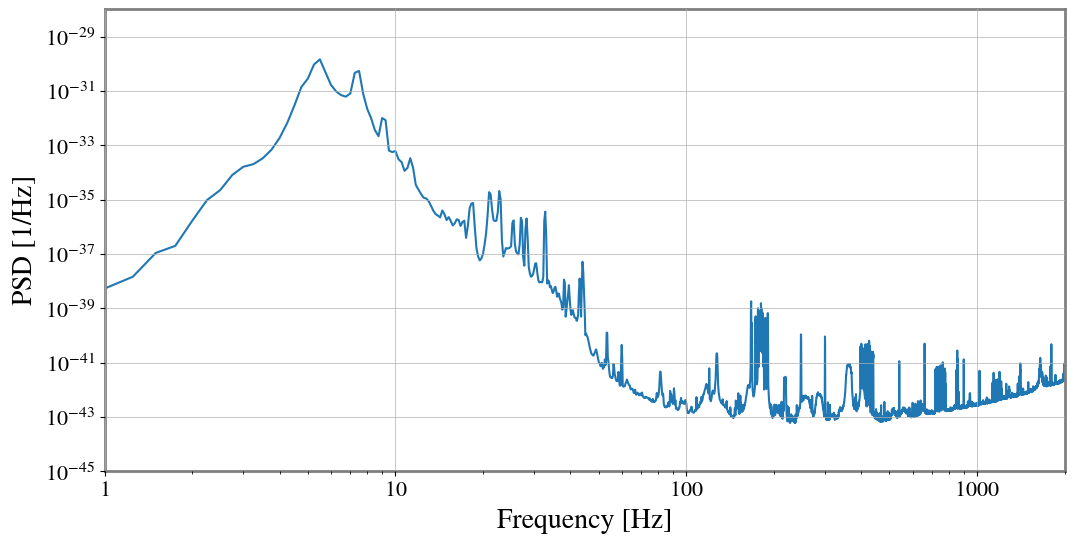

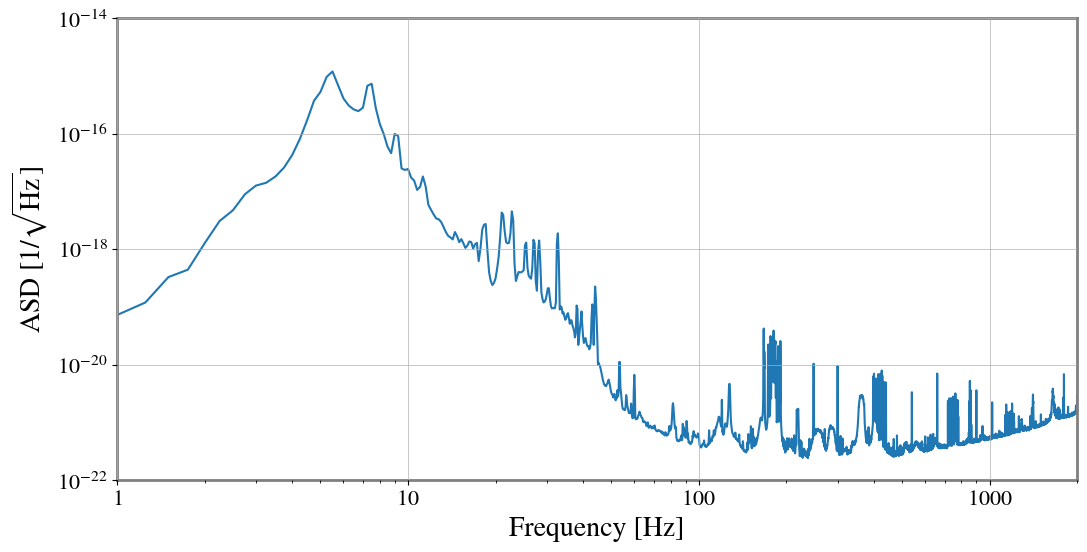

In [12]:
psd = data.psd(fftlength=fftlength, overlap=fftlength/2)
plot = psd.plot(figsize=[12,6])
ax = plot.gca()
ax.set_xlim(1, 2000)
ax.set_ylim(1e-45, 1e-28)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'PSD [1/$\mathrm{Hz}}$]')

asd = data.asd(fftlength=fftlength, overlap=fftlength/2)
plot = asd.plot(figsize=[12,6])
ax = plot.gca()
ax.set_xlim(1, 2000)
ax.set_ylim(1e-22, 1e-14)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel(r'ASD [1/$\sqrt{\mathrm{Hz}}$]')